# B sensitivity test
Here we check how the B parameter of Holland (1980) changes across all the different TCs that we have in the dataset. To do so, we first sort the TCs by category. Second, we define a piecewise B: B1 for the inner-core, B2 for the region right after the eyewall and B3 for the outer region. Then, we check how B1, B2 and B3 are modified as a function of the generak shape of the TC (asymmetry, presence of certain rainbands, etc...). 

The radii R1 and R2 corresponding to the 3 pieces on which the profile is defined are computed as Rmax for R1 and then a cubic fraction of Rmax for R2.

When we allowed A to vary, the piecewise fitting had a larger RMSE than the Holland fitting, and the piecewise profile was really bad for a significant part of the TCs. It's even worse when A is fixed. 

Clearly, the way we define Rfit will be crucial. Maybe we should also test with only 2 pieces (at Rmax, or Rmerge from Chavas). We can also use Rmerge from Chavas as R2. 

<ins>FIRST EXPERIMENT:</ins>
We fit a classic Holland profile V_holland to the data. This gives us pn_fit, pc_fit, Vmin_fit, A_fit, and B_fit.
Then, we use these values to initialize a 2B-Holland model. This model has 2 parameters: B for the inner-core (r < R1) and B1 for the outer-core (r > R1). In this experiment B will be fixed to B_fit. We also initialize R1 to Rmax. 

Then, we fit this 2B-Holland model to the data, allowing R1 to be optimized. 

In most cases, this didn't change the RMSE. In a few cases ($\sim$20, check cases 58 and 59 for instance), this improved the RMSE by $\sim$0.01, and B1_fit differed by $\sim$0.01 from the inner-core B_fit. In more cases ($\sim$40), the new model was completely wrong (whereas the simple Holland model was quite good). 

<ins>SECOND EXPERIMENT (not shown):</ins>
This time we fix B1 (outer-core) to B_fit, and allow B (inner-core) to vary. R1 also varies during the optimization. 

Here, the new model is never better than the simple Holland model. In many cases ($\sim$100) it even has a slightly larger RMSE ($\sim$0.1) than the simple model, because B (this time inner-core) is modified by $\sim$0.02. Cases 9 - 10 are representative of this. In some cases ($\sim$40) the new model is completely wrong, as in the previous experiment. 

TODO: Continuity? If A Varies? 




In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import glob

import functions as f

In [2]:
### PATHS
dir_path = '/home/arthur/data/cyclobs/rotated_files/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))
# Categories: 'dep', 'storm', 'cat-1', 'cat-2', 'cat-3', 'cat-4', 'cat-5'
# Nb of TCs:    1,      139,     88,      44,      57,      37,      19

### PARAMS
PARAMS = {
    'print_params_values': False
    }

Total number of files: 385


In [3]:
### INITIALIZE DATA STRUCTURE
INI = {           # Initial values
    'Holland':   [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'B_sens':    [], # rho, Lat, R1, V1, pn, pc, Vmin, A, B
    'Chavas':    []  # Vmax, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye
    } 
FIT = {           # Fit values
    'Holland':   [], # Lat, pn, pc, Vmin, A, B
    'B_sens':    [], # R1, pn, pc, Vmin, A, B0, B1
    'Chavas':    []  # rr, VV, rmax, r0, rmerge, Vmerge
    } 

1 =>     /home/arthur/data/cyclobs/rotated_files/s1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_ll_gd_rotated.nc
2 =>     /home/arthur/data/cyclobs/rotated_files/rs2--owi-cm-20150601t015945-20150601t020101-00003-BDBF8_ll_gd_rotated.nc
3 =>     /home/arthur/data/cyclobs/rotated_files/s1a-ew-owi-cm-20160827t092124-20160827t092414-000003-014249_ll_gd_rotated.nc
4 =>     /home/arthur/data/cyclobs/rotated_files/s1a-ew-owi-cm-20170207t015253-20170207t015558-000003-018D33_ll_gd_rotated.nc
5 =>     /home/arthur/data/cyclobs/rotated_files/rs2--owi-cm-20141020t163921-20141020t164037-00003-E0949_ll_gd_rotated.nc
6 =>     /home/arthur/data/cyclobs/rotated_files/s1b-iw-owi-cm-20201020t095807-20201020t095922-000003-02D69A_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:586: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


7 =>     /home/arthur/data/cyclobs/rotated_files/s1a-iw-owi-cm-20190827t095110-20190827t095204-000003-03418D_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:586: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


8 =>     /home/arthur/data/cyclobs/rotated_files/rs2--owi-cm-20150509t232412-20150509t232525-00003-E0BD7_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:586: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


9 =>     /home/arthur/data/cyclobs/rotated_files/s1b-ew-owi-cm-20191010t085239-20191010t085526-000003-022AE7_ll_gd_rotated.nc
10 =>     /home/arthur/data/cyclobs/rotated_files/s1a-ew-owi-cm-20181002t211106-20181002t211310-000003-029DF5_ll_gd_rotated.nc


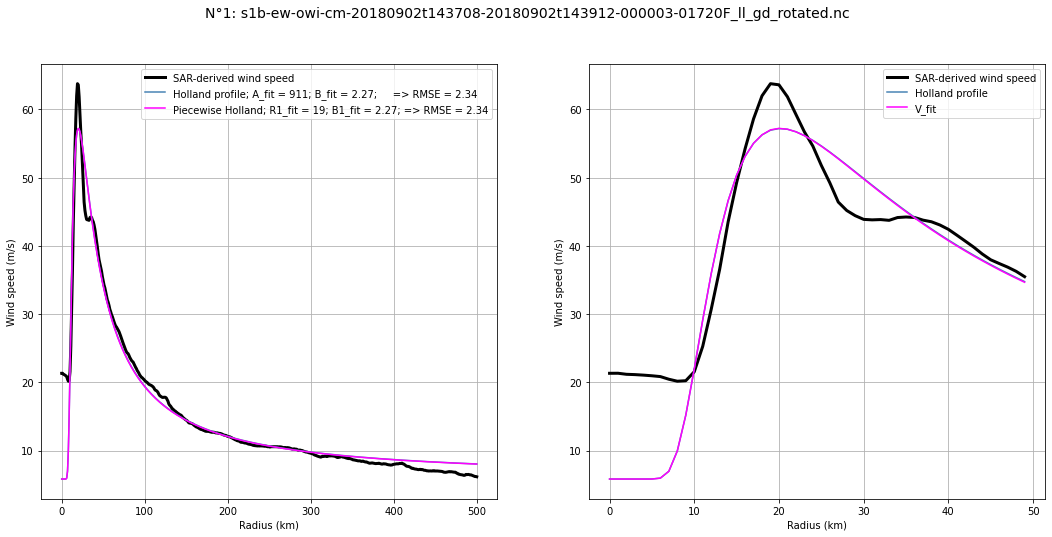

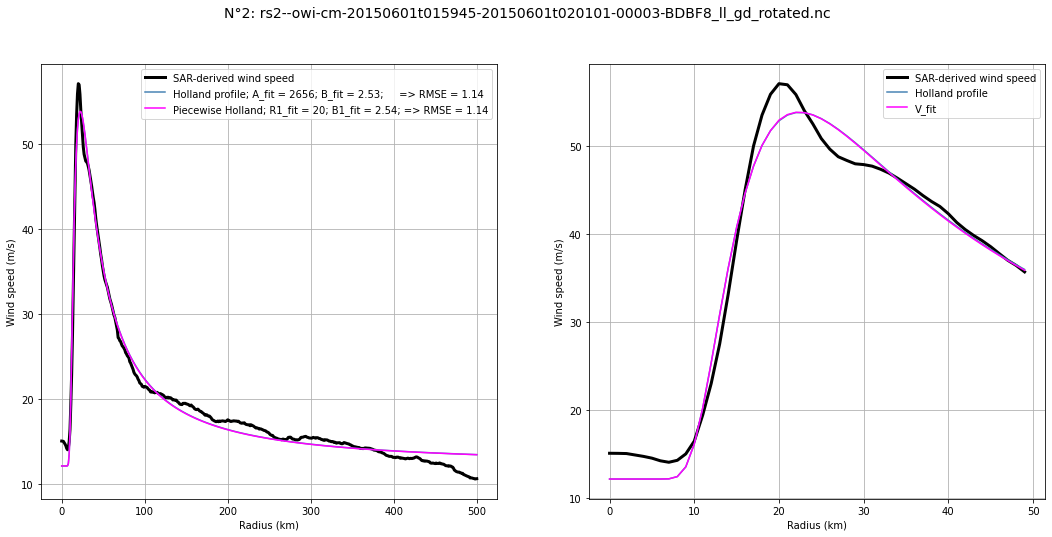

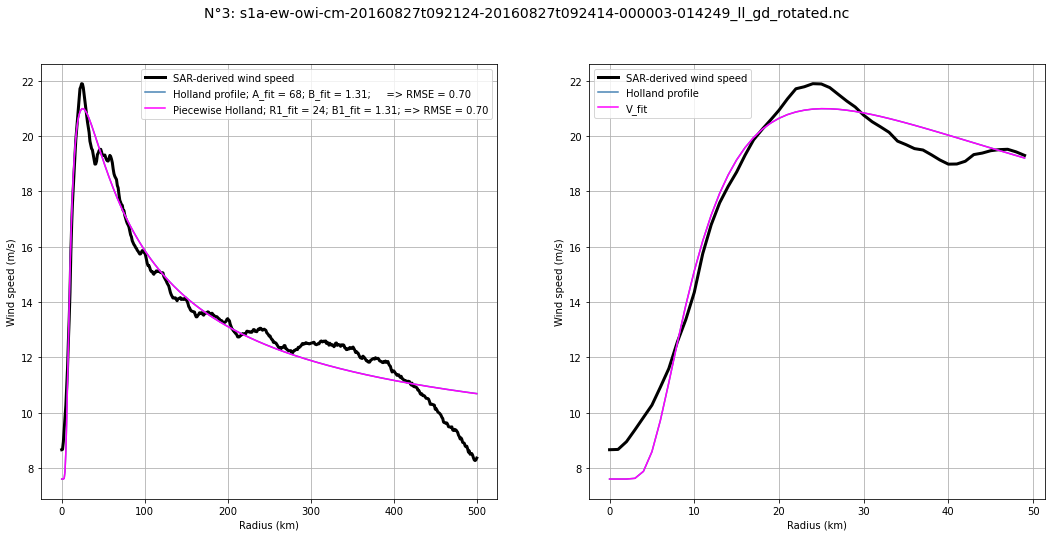

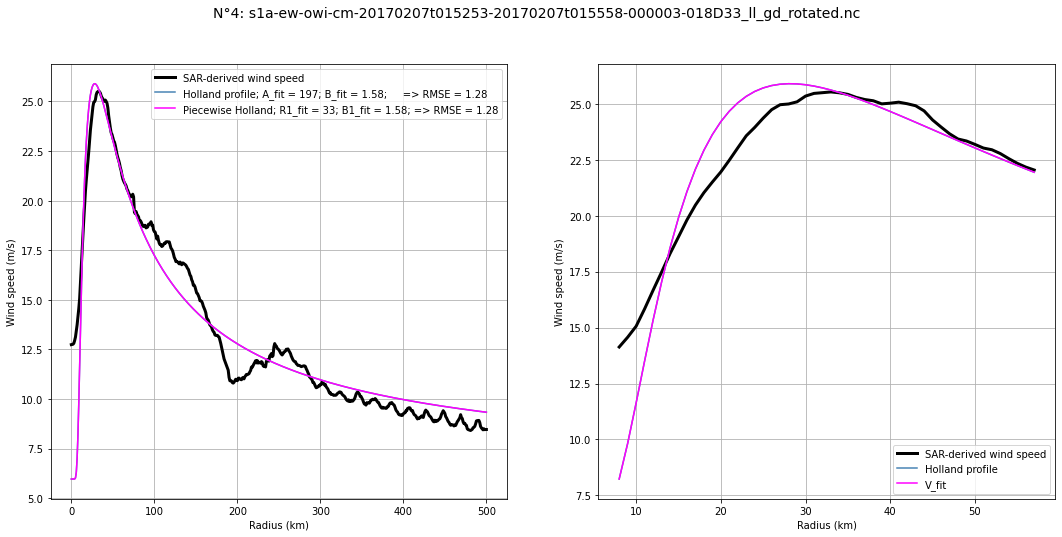

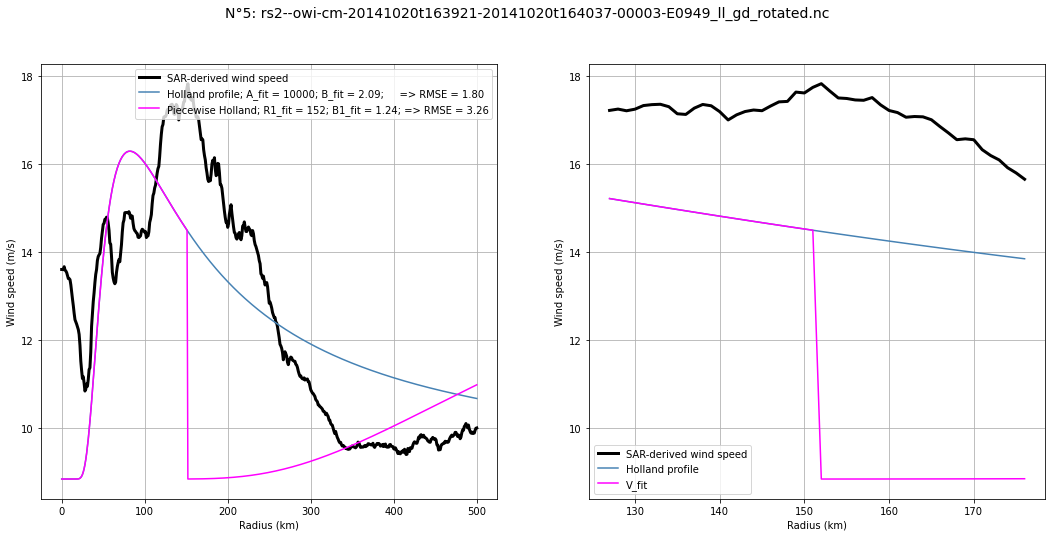

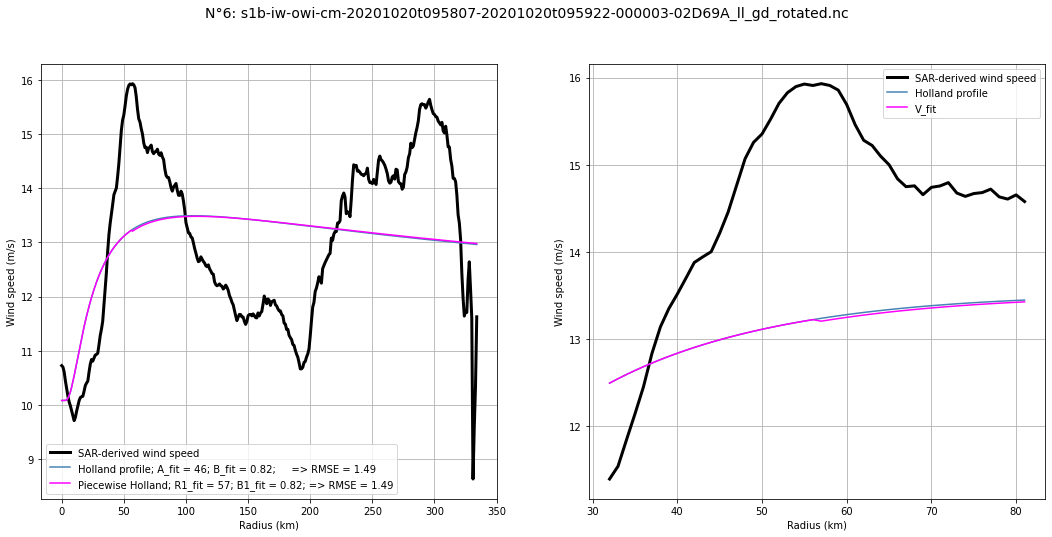

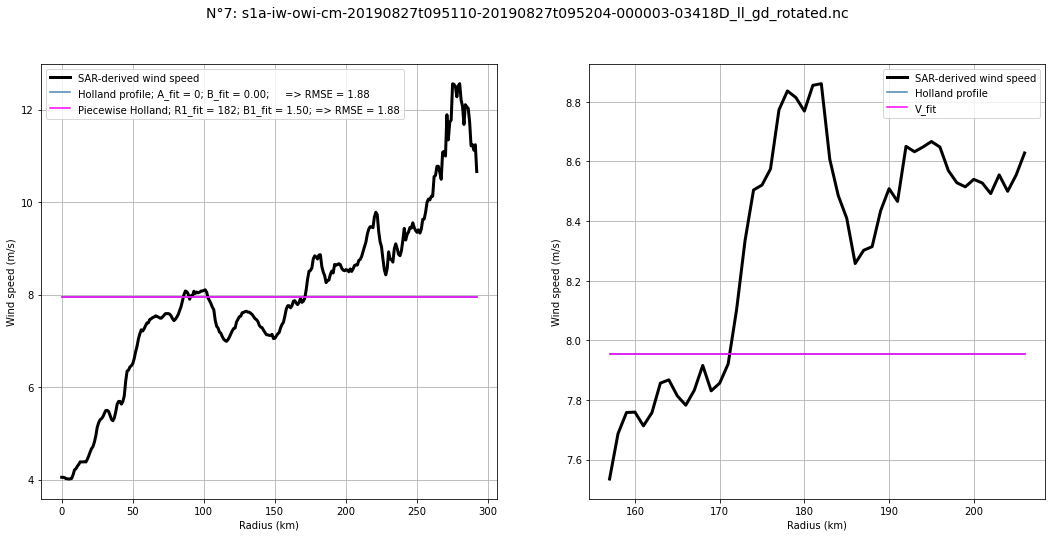

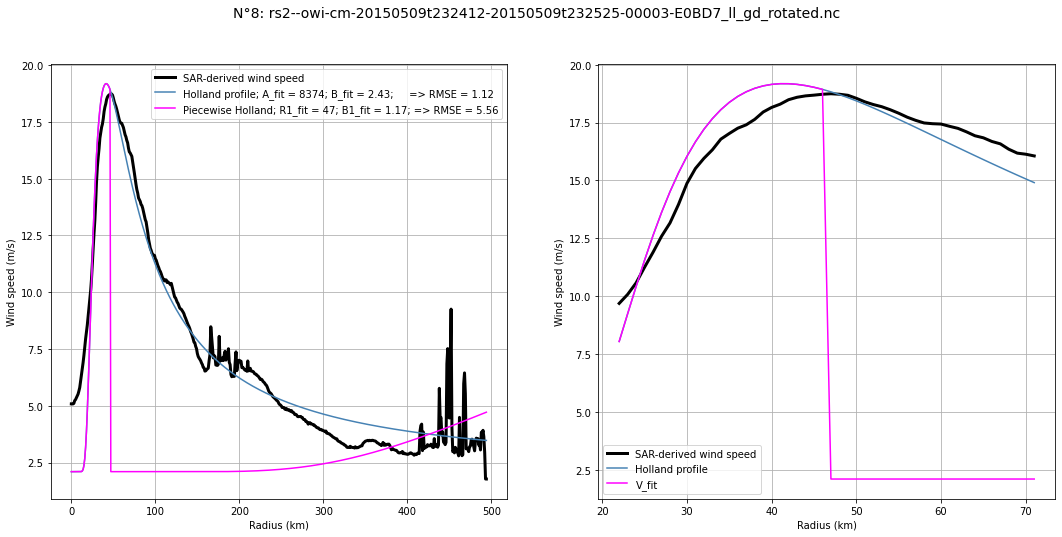

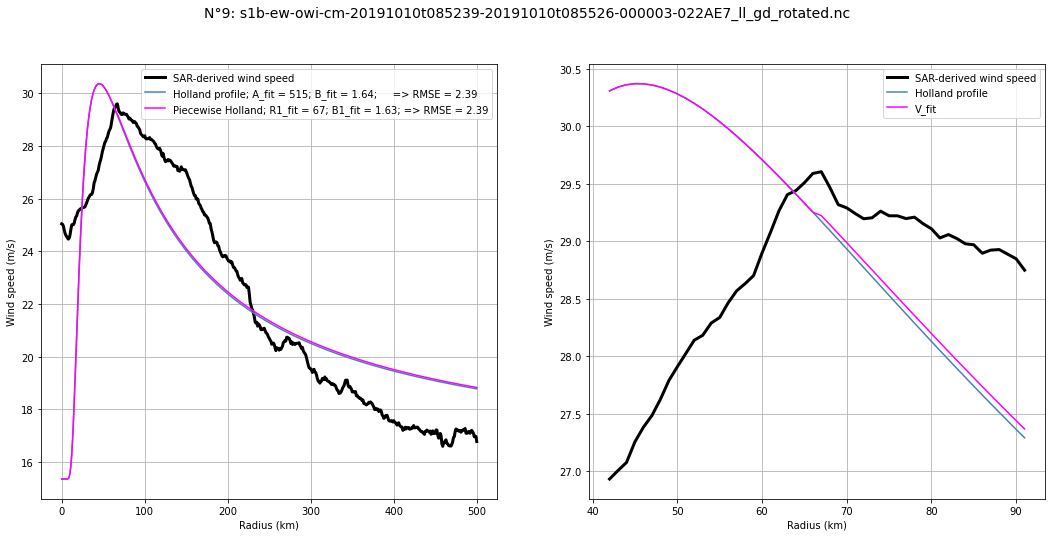

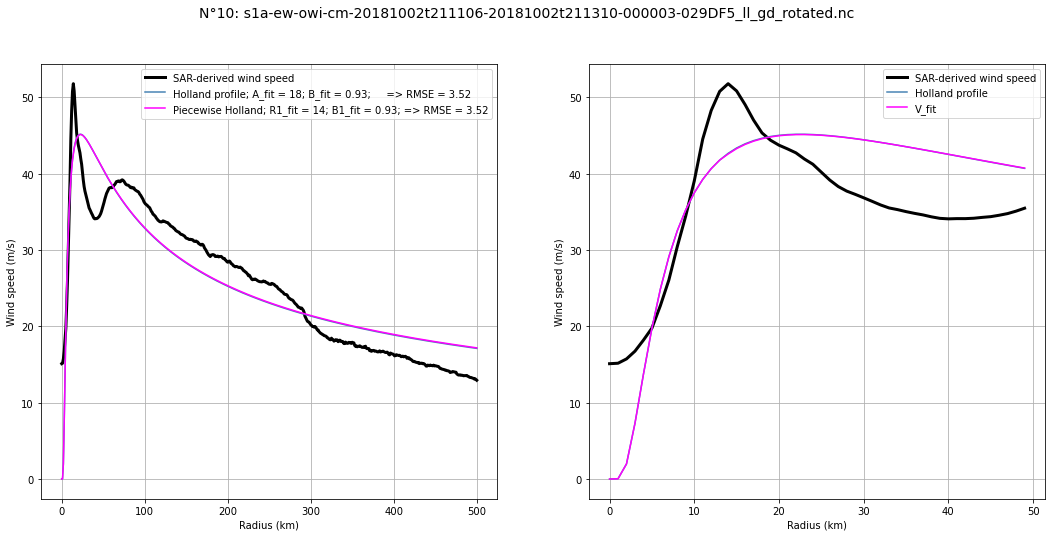

In [5]:
### FIRST EXPERIMENT: We fix B (inner-core) but B1, R1 vary. # Interesting cases: [58:60]
i = 0 
for file in all_data[0:10]:
    i += 1
    print(i, "=>    ", file)
    # Open file and compute mean wind speed
    ds   = xr.open_dataset(file)
    # print(ds['current_category'])
    spdm    = f.compute_mean_wind_spd(ds, 501)
    
    # Initialize and fit profile
    r, spdm       = f.initialize_radius(spdm)
    
    
    INI['Holland'] = f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, print_values=PARAMS['print_params_values'])
    Lat, pn, pc, Vmin, _, _ = INI['Holland']
    FIT['Holland'] = f.fit_holland_AB(r, spdm, Lat=Lat, rho=1.15, pn=pn, pc=pc, Vmin=Vmin, A=50., B=1.5, print_values=PARAMS['print_params_values'])
    # _, pn_fit, pc_fit, Vmin_fit, A_fit, B_fit = FIT['Holland']
    
    # INI['B_sens'] = f.initialize_twoB_sensitivity_experiment(spdm, power_law=3, rho=1.15, Lat=ds['lat_ref'], pn=1005 * 100., pc=950 * 100., print_values=PARAMS['print_params_values'])
    FIT['B_sens'] = f.fit_twoB_test_sensitivity_experiment(r, spdm, 1.15, *FIT['Holland'], print_values=PARAMS['print_params_values'])
    
    
    # f.plot_twoB_sensitivity_experiment(i, file, r, spdm, INI, FIT) 
    f.plot_twoB_test_sensitivity_experiment(i, file, r, spdm, INI, FIT)
    
   
    